# Base Model: Logistic Regression

Topic modeling is an unsupervised machine learning technique used to detect words and phrases within documents                                                                                                                                                    and automatically cluster groups of words and similar expressions that best characterize a set of documents.

This NLP technique is useful for tasks including text classification, extracting themes from documents, and building a recommender systems to recommend other text such as an article.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import seaborn as sns

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

### Load Data

In [2]:
with open("cleaned_data.json") as f:
    df_data = pd.read_json(f)
df_data.drop(columns=['company', 'location', 'salary', 'position', 'position2', 'level'], inplace=True)

In [4]:
df_data.describe(include='all')

,jobtitle,jobdescription,label
count,468,468,468.000000
unique,357,464,NaN
top,Data Scientist,Company Bio IMAGINE a hospital where everyone ...,NaN
freq,38,2,NaN
mean,NaN,NaN,0.290598
std,NaN,NaN,0.454524
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


According to this, we actually have 4 duplicate job descriptions.

## Create Train and Test Data Sets

Here, we will divide the dataset into training and test data sets using sklearn's train_test_split method. Using this approach instead of dividing directly into X test, X train, y test, and y train data will allow for the text data being used for X train cannot include any information that the X test would provide, thus preventing data leakage.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_data['jobdescription'], df_data['label'],
                               test_size=0.30,
                               random_state=123,
                               stratify= df_data['label'])


print("x_train shape is", x_train.shape, " and x_test shape is ", x_test.shape)
print("y_train shape is", y_train.shape, " and y_test shape is ", y_test.shape)

x_train shape is (327,)  and x_test shape is  (141,)
y_train shape is (327,)  and y_test shape is  (141,)


Use TF-IDF to extract features before fitting the classifer.

In [6]:
# create custom stopwords set
combined_stopwords = ENGLISH_STOP_WORDS.union(stopwords.words('french'))
custom_stopwords = ['data', 'scientist', 'science', 'scientist', 'skills', 'ability', 'bachelor', 'degree', 'work', 'years', 'equal', 'opportunity', 'employer', 'objectives', 'ontario', 'canada', 'disability', 'strong', 'including', 'understanding', 'related', 'experience', 'including', 'job', 'requirements']

#combine custom_stopwords and combined_stopwords from above
custcomb_stopwords = combined_stopwords.union(custom_stopwords)

# Initialize TFIDF Vectorizer
tvec = TfidfVectorizer(analyzer = 'word',  
                       stop_words = custcomb_stopwords, 
                       lowercase= True, 
                       min_df=4
                       )

In [7]:
# Fit text data
tvec.fit(x_train)

x_train_tfidf = tvec.transform(x_train.values)
x_test_tfidf = tvec.transform(x_test.values)

print("x train shape", x_train_tfidf.shape)
print("x test shape", x_test_tfidf.shape)

x train shape (327, 3203)
x test shape (141, 3203)


## Baseline Model with Log Reg

In [8]:
logreg = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits= 5, random_state= 7, shuffle= True)
clf_result = cross_val_score(logreg, x_train_tfidf, y_train, cv=kfold, scoring='roc_auc')
print("The mean of cross validation is: ", clf_result.mean())

The mean of cross validation is:  0.9824084921411014


### Evaluation Metrics of Test data

In [9]:
# Predict y values using x test values
model = logreg.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)
precision, recall, fscore, support = score(y_test, 
                                            y_pred, 
                                            pos_label=1, 
                                            average ='binary')

print("Classification Report: \nPrecision: {}, \nRecall: {}, \nAccuracy: {}".format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))

Classification Report: 
Precision: 1.0, 
Recall: 0.659, 
F-score: 0.794, 
Accuracy: 0.901


Text(0.5, 12.0, 'Predicted Label')

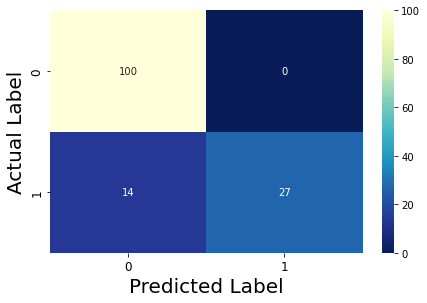

In [10]:
# Plot confusion matrix
class_labels = ["Data Analyst(0)", "Data Scientist (1)"]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 12)
plt.yticks(tick_marks, class_labels, fontsize = 12)

# Create heatmap
conf_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu_r", fmt='g')
plt.tight_layout()
plt.ylabel("Actual Label", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)

In [11]:
# classifiction metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       100
           1       1.00      0.66      0.79        41

    accuracy                           0.90       141
   macro avg       0.94      0.83      0.86       141
weighted avg       0.91      0.90      0.89       141



### Create a DF to hold Prediction Outcomes

In [12]:
job_df = pd.DataFrame(y_test.values, columns=['Actual'])
job_df['Prediction for 1'] = y_pred
job_df['Prediction Probability for 0 (Analyst)'] = model.predict_proba(x_test_tfidf)[:,0]
job_df['Prediction Probability for 1 (Scientist)'] = model.predict_proba(x_test_tfidf)[:,1]
job_df.head(10)

,Actual,Prediction for 1,Prediction Probability for 0 (Analyst),Prediction Probability for 1 (Scientist)
0,0,0,0.885389,0.114611
1,0,0,0.746971,0.253029
2,0,0,0.801984,0.198016
3,0,0,0.872286,0.127714
4,1,0,0.510285,0.489715
5,1,1,0.386985,0.613015
6,0,0,0.891809,0.108191
7,0,0,0.777460,0.222540
8,0,0,0.857545,0.142455
9,1,0,0.707452,0.292548


### ROC Curve

Receiver Operating Characteristic (ROC) curve is a performance metric for binary clssification problems, which plots the true positive rate (tpr) against the false positive rate (fpr). The Area Under the Curve (AUC) represents a model's ability to discriminate between the two classes.

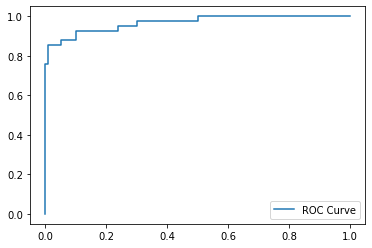

In [13]:
y_pred_proba = model.predict_proba(x_test_tfidf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="ROC Curve")
plt.legend(loc=4)
plt.show()

In [14]:
# area under the curve metric
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("The AUC is ", auc)

The AUC is  0.9675609756097561


### Learning Curve

In [ ]:
from custom_utils import learning_curve

plot_learning_curve(model, x_train_tfidf, y_train, scoring='accuracy', figsize=(6,4))

## Save Model

Here, we can save the model we've developed.

In [15]:
import pickle

filename = 'jobmarket_logreg.pkl'
pickle.dump(model, open(filename, 'wb'))

## Further Inspection of our Model

### Important Words

To better understand how out classifier is making decisions, we'll look at which features are considered important and which ones aren't.

Recall from earlier, we used logreg as an instance for LogReg. "model" is the log reg clf fit to training data. tvec an instance of TFIDF vectorizer.

In [16]:
# get most important features

def get_most_important_features(vectorizer, model, n=5):
    '''Function returns most important words to differentiate between binary classification.'''
    # use vocabulary attribute to access mapping of terms to feature indices
    index_to_word = {vec:key for key,vec in vectorizer.vocabulary_.items()}

    classes = {}
    for class_index in range(model.coef_.shape[0]): # range(1)
        # access coefficient
        word_importances = [(ec, index_to_word[i]) for i, ec in enumerate(model.coef_[class_index])]
        sorted_coef = sorted(word_importances, key = lambda x: x[0], reverse=True)
        # assign highest sorted value to top
        tops = sorted(sorted_coef[:n], key = lambda x: x[0])
        # assign lowest sorted values to var bottom
        bottom = sorted_coef[-n:]
        classes[class_index] = {'top': tops, 'bottom': bottom}
    return classes


In [17]:
importance = get_most_important_features(tvec, model, 10)
importance

{0: {'top': [(0.774985472326483, 'predictive'),
   (0.80481306096562, 'engineering'),
   (0.8073435263436867, 'ml'),
   (0.811887292294547, 'python'),
   (0.8746207996864245, 'deep'),
   (0.899456057969558, 'statistical'),
   (1.090006915914013, 'algorithms'),
   (1.3393739932210957, 'models'),
   (2.5758133818610176, 'machine'),
   (2.6569714896837655, 'learning')],
  'bottom': [(-0.4920220013775421, 'excel'),
   (-0.5111929950448622, 'market'),
   (-0.5244487358223723, 'project'),
   (-0.5432898574393911, 'risk'),
   (-0.6531820333949069, 'support'),
   (-0.6703828605420851, 'reports'),
   (-0.7404296042515731, 'reporting'),
   (-0.7622558303611562, 'sales'),
   (-0.7648244479473533, 'management'),
   (-1.0050259897689622, 'business')]}}

### Plot the most important words

We just combined the vocab words with coefficient/score and is now stored in "importance" variable.

Plot the words vs scores for both the top and bottom scoring words.

In [19]:
# first we need to separate the words from the scores
top_scores = [a[0] for a in importance[0]['top']]
top_words = [a[1] for a in importance[0]['top']]
bottom_scores = [-a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

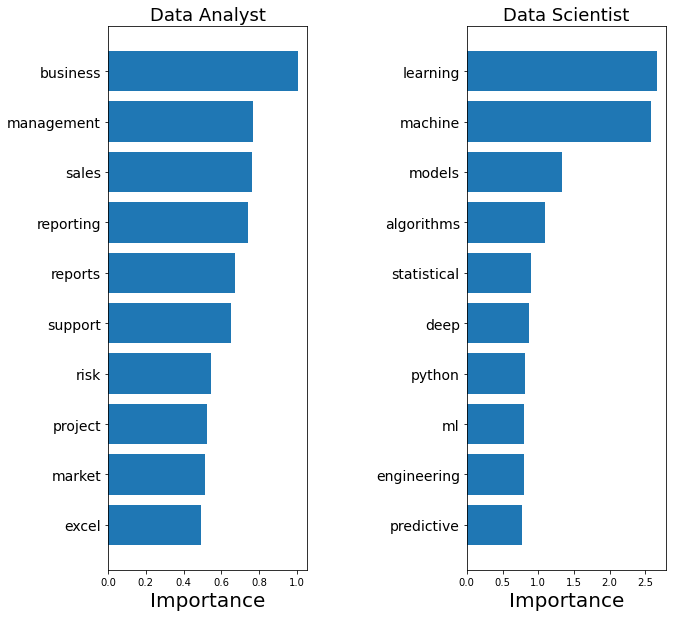

In [20]:
# Plot the word importance for each class
fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.barh(bottom_words, bottom_scores)
plt.title("Data Analyst", fontsize=18)
plt.yticks(bottom_words, fontsize=14)
plt.xlabel('Importance', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(top_words, top_scores)
plt.title("Data Scientist", fontsize=18)
plt.yticks(top_words, fontsize=14)
plt.xlabel('Importance', fontsize=20)

plt.subplots_adjust(wspace = 0.8)
plt.show()

### Compare top skills

Compare the top skills found with feature importance through modeling with the skills identified through pattern matching (EDA).

In [66]:
# import top skills identifies by pattern matching
analyst10 = pd.read_csv("top10_analyst_skills.csv")
scientist10 = pd.read_csv("top10_scientist_skills.csv")

# convert to list
analyst10_patt = set(analyst10['Skill'].str.lower().tolist())
scientist10_patt = set(scientist10['Skill'].str.lower().tolist())

In [71]:
# most important words from log reg model
analyst10_log = set(bottom_words)
scientist10_log = set(top_words)

In [73]:
# analyst
analyst_both = set(analyst10_patt).intersection(analyst10_log)
print("Analyst skills in both:\n", analyst_both)
an_patt_only = set(analyst10_patt).difference(analyst10_log)
print("Analyst skills in pattern matching only:\n", an_patt_only)
an_log_only = analyst10_log.difference(set(analyst10_patt))
print("Analyst words found by modeling:\n", an_log_only)

Analyst skills in both:
 {'excel'}
Analyst skills in pattern matching only:
 {'research', 'tableau', 'python', 'database', 'power bi', 'ad-hoc', 'statistics', 'sql', 'visualization'}
Analyst skills found by modeling:
 {'support', 'project', 'sales', 'reporting', 'reports', 'market', 'management', 'business', 'risk'}


In [75]:
# scientist
scientist_both = scientist10_patt.intersection(scientist10_log)
print("Data scientist skills in both:\n",scientist_both)
patt_only = scientist10_patt.difference(scientist10_log)
print("Data scientist skills in pattern matching:\n",patt_only)
sci_log_only = scientist10_log.difference(scientist10_patt)
print("Data scientist words found by modeling:\n", sci_log_only)

Data scientist in both:
 {'python'}
Data scientist skills in pattern matching:
 {'research', 'r', 'spark', 'machine learning', 'tableau', 'statistics', 'sql', 'hadoop', 'visualization'}
Data scientist skills found by modeling:
 {'deep', 'machine', 'predictive', 'statistical', 'engineering', 'algorithms', 'ml', 'models', 'learning'}


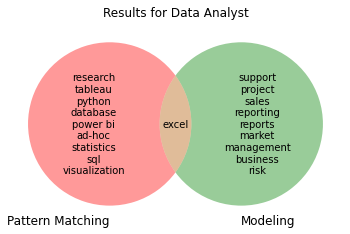

In [80]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Data Analyst results
fig1 = venn2([analyst10_patt, analyst10_log], set_labels = ('Pattern Matching', 'Modeling'))
# add text
fig1.get_label_by_id("10").set_text("\n".join(analyst10_patt - analyst10_log))
fig1.get_label_by_id("11").set_text("\n".join(analyst10_patt & analyst10_log))
fig1.get_label_by_id("01").set_text("\n".join(analyst10_log - analyst10_patt))
plt.title('Results for Data Analyst')
plt.show()

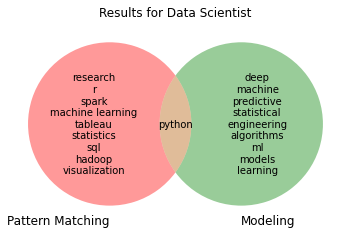

In [81]:
fig2 = venn2([scientist10_patt, scientist10_log], set_labels = ('Pattern Matching', 'Modeling'))
# add text
fig2.get_label_by_id("10").set_text("\n".join(scientist10_patt - scientist10_log))
fig2.get_label_by_id("11").set_text("\n".join(scientist10_patt & scientist10_log))
fig2.get_label_by_id("01").set_text("\n".join(scientist10_log - scientist10_patt))
plt.title('Results for Data Scientist')
plt.show()